In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            12G        1.4G        9.2G        1.2M        2.1G         11G
Swap:            0B          0B          0B


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

In [4]:
os.makedirs("celebas_gan")
url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celebas_gan/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celebas_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celebas_gan")

In [5]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "celebas_gan", label_mode=None, image_size=(64, 64), batch_size=32)
dataset = dataset.map(lambda x: x / 255.0)


Found 202599 files belonging to 1 classes.


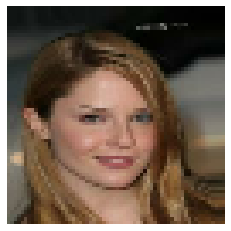

In [6]:

for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break


In [7]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

In [8]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=3, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      147584    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      295168    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

In [12]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Lấy mẫu các điểm ngẫu nhiên trong không gian tiềm ẩn
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Giải mã chúng thành hình ảnh giả mạo
        generated_images = self.generator(random_latent_vectors)

        # kết hợp hình ảnh giả mạo vừa tạo với hình ảnh thật
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Gắn nhãn 1 cho ảnh giả và  nhãn 0 cho ảnh thật
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Thêm nhiễu ngẫu nhiên vào các nhãn
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Lấy mẫu các điểm ngẫu nhiên trong không gian tiềm ẩn
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Tập hợp các nhãn 0 của hình ảnh thật
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator 
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics( Cập nhật các ma trận loss)
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
       # history.append( (d_loss, g_loss) )
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        # self.d_loss_metric= d_loss
        # self.g_loss_metric= g_loss

    def on_epoch_end(self, epoch, logs=None,):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
  
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(OUTPUT_DIR + "/" +  "generated_img_%03d_%d.png" % (epoch, i))
            generator.save(SAVE_PATH +  'faces_g_' + str(epoch) + '.h5')
            discriminator.save(SAVE_PATH + 'faces_d_' + str(epoch) + '.h5')
            #gan.save(SAVE_PATH + 'gan_' + str(epoch) + '.h5')
            # # Plot losses
            # plt.plot( metrics.d_loss_metric , label='Discriminator', alpha=0.6)
            # plt.plot(g_loss_metric, label='Generator', alpha=0.6)
            # plt.title("Losses")
            # plt.legend()
            # plt.savefig(LOSS_PATH+ "losses_" + str(epoch) + ".png")
            # plt.close()
# Path to project folder
BASE_PATH = "/content/drive/MyDrive/GR3/"
# Path to folder with checkpoints and which epoch to load
#START_EPOCH = None
#LOAD_WEIGHTS_PATH = BASE_PATH + '/models'

#DATASET_LIST_PATH = BASE_PATH + "/input/image.txt"
#INPUT_DATA_DIR = "/content/drive/MyDrive/GR3/TrainDeepFake/train/real/"
OUTPUT_DIR = BASE_PATH + '/output'
SAVE_PATH = BASE_PATH + '/models'
LOSS_PATH = BASE_PATH + '/loss'

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
if not os.path.exists(LOSS_PATH):
    os.makedirs(LOSS_PATH)

In [ ]:
epochs = 50  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

historys= gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

Epoch 1/50
6332/6332 [==============================] - 1192s 188ms/step - d_loss: 0.6498 - g_loss: 1.0288
Epoch 2/50
6332/6332 [==============================] - 1173s 185ms/step - d_loss: 0.6566 - g_loss: 0.9685
Epoch 3/50
6332/6332 [==============================] - 1176s 186ms/step - d_loss: 0.6174 - g_loss: 1.0563
Epoch 4/50
6332/6332 [==============================] - 1173s 185ms/step - d_loss: 0.6080 - g_loss: 1.0581
Epoch 5/50
6332/6332 [==============================] - 1182s 187ms/step - d_loss: 0.6244 - g_loss: 1.0133
Epoch 6/50
6332/6332 [==============================] - 1189s 188ms/step - d_loss: 0.6457 - g_loss: 0.9513
Epoch 7/50
6332/6332 [==============================] - 1202s 190ms/step - d_loss: 0.6555 - g_loss: 0.9240
Epoch 8/50
6332/6332 [==============================] - 1205s 190ms/step - d_loss: 0.6601 - g_loss: 0.9044
Epoch 9/50
6332/6332 [==============================] - 1203s 190ms/step - d_loss: 0.6639 - g_loss: 0.8978
Epoch 10/50
1845/6332 [=======>......

In [ ]:
fig, ax = plt.subplots()
losses = np.array(historys)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
with open("/content/drive/MyDrive/GR3/loss.txt",'w') as f:
    for k in historys.history.keys():
        print(k,file=f)
        for i in historys.history[k]:
            print(i,file=f)